# Anomaly-Detection
is the identification of rare items, events or observations which raise suspicions by differing significantly from the majority of the data.

**Project : Credit Card Fraud Detection**

The use of the latest technology by criminals is becoming increasingly complex with the methods of credit card fraud. Unless the customer reports it, it is no longer a simple task to identify outliers/anamolous transactions beforehand. This means that when dealing with financial information or sensitive customer data, the use of machine-learning algorithms becomes imperative because these algorithms can examine data volumes including text, images and videos, analyze a pattern, and detect an anomaly in seconds, with high precision. Now we have many supervised and uncontrolled methods of learning, but it's a great task to choose the algorithm.

### Import Requirements

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from imblearn.over_sampling import KMeansSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)

### Load Data 

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

#### Unique Classes

In [4]:
df.Class.unique()

array([0, 1], dtype=int64)

- 1 for fraudulent transactions, 0 otherwise

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

#### Frequency Distribution : 

Text(0, 0.5, 'Frequency')

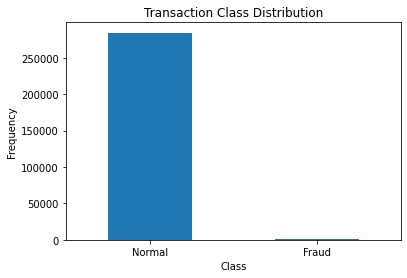

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
LABELS = ["Normal", "Fraud"]
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

- Fraudulent transactions provided in this section only contribute 0.17%, which indicates that we have very unequal data.

### Distribution: Amount

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='Amount', ylabel='Density'>

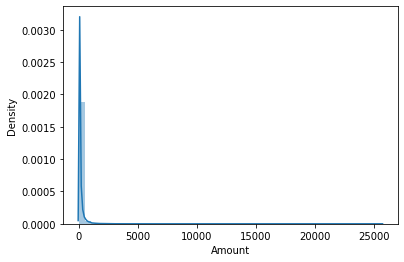

In [7]:
sns.distplot(df['Amount'])

In [8]:
#Determine the number of fraud and valid transactions in the dataset
Fraud = df[df['Class']==1]
Valid = df[df['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))
outlier_fraction

0.0017304750013189597

#### For now remember Epsilon value is the threshold value below which we will mark transaction as Anomalous.
Rewriting above sentense again P(x) for X if less than the epsilon value then mark that transaction as anomalous transaction.

We need to maintain healthy balance between the Recall and Precision . We may get Recall value above 0.80 and close to 0.90 here but at the expense of reducing our precision which is not advisable.

In [9]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

In [10]:
def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    farray = []
    Recallarray = []
    Precisionarray = []
    epsilons = (0.0000e+00, 1.0527717316e-70, 1.0527717316e-50, 1.0527717316e-24)
    for epsilon in epsilons:
        predictions = (p_cv < epsilon)
        f = f1_score(train_cv_y, predictions, average = "binary")
        Recall = recall_score(train_cv_y, predictions, average = "binary")
        Precision = precision_score(train_cv_y, predictions, average = "binary")
        farray.append(f)
        Recallarray.append(Recall)
        Precisionarray.append(Precision)
        print ('For below Epsilon')
        print(epsilon)
        print ('F1 score , Recall and Precision are as below')
        print ('Best F1 Score %f' %f)
        print ('Best Recall Score %f' %Recall)
        print ('Best Precision Score %f' %Precision)
        print ('-'*40)
        if f > best_f1:
            best_f1 = f
            best_recall = Recall
            best_precision = Precision
            best_epsilon = epsilon    
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.7, 0.3])
    #plt.subplot(3,1,1)
    plt.plot(farray ,"ro")
    plt.plot(farray)
    ax.set_xticks(range(5))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('F1 score vs Epsilon value')
    ax.annotate('Best F1 Score', xy=(best_epsilon,best_f1), xytext=(best_epsilon,best_f1))
    plt.xlabel("Epsilon value") 
    plt.ylabel("F1 Score") 
    plt.show()
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    #plt.subplot(3,1,2)
    plt.plot(Recallarray ,"ro")
    plt.plot(Recallarray)
    ax.set_xticks(range(5))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('Recall vs Epsilon value')
    ax.annotate('Best Recall Score', xy=(best_epsilon,best_recall), xytext=(best_epsilon,best_recall))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Recall Score") 
    plt.show()
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    #plt.subplot(3,1,3)
    plt.plot(Precisionarray ,"ro")
    plt.plot(Precisionarray)
    ax.set_xticks(range(5))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('Precision vs Epsilon value')
    ax.annotate('Best Precision Score', xy=(best_epsilon,best_precision), xytext=(best_epsilon,best_precision))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Precision Score") 
    plt.show()
    return best_f1, best_epsilon

In [11]:
v_features = df.iloc[:,1:29].columns

In [12]:
v_features

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

#### Lets visualize which features are not much of help in detecting the anamoly 

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function f

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function f

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function f

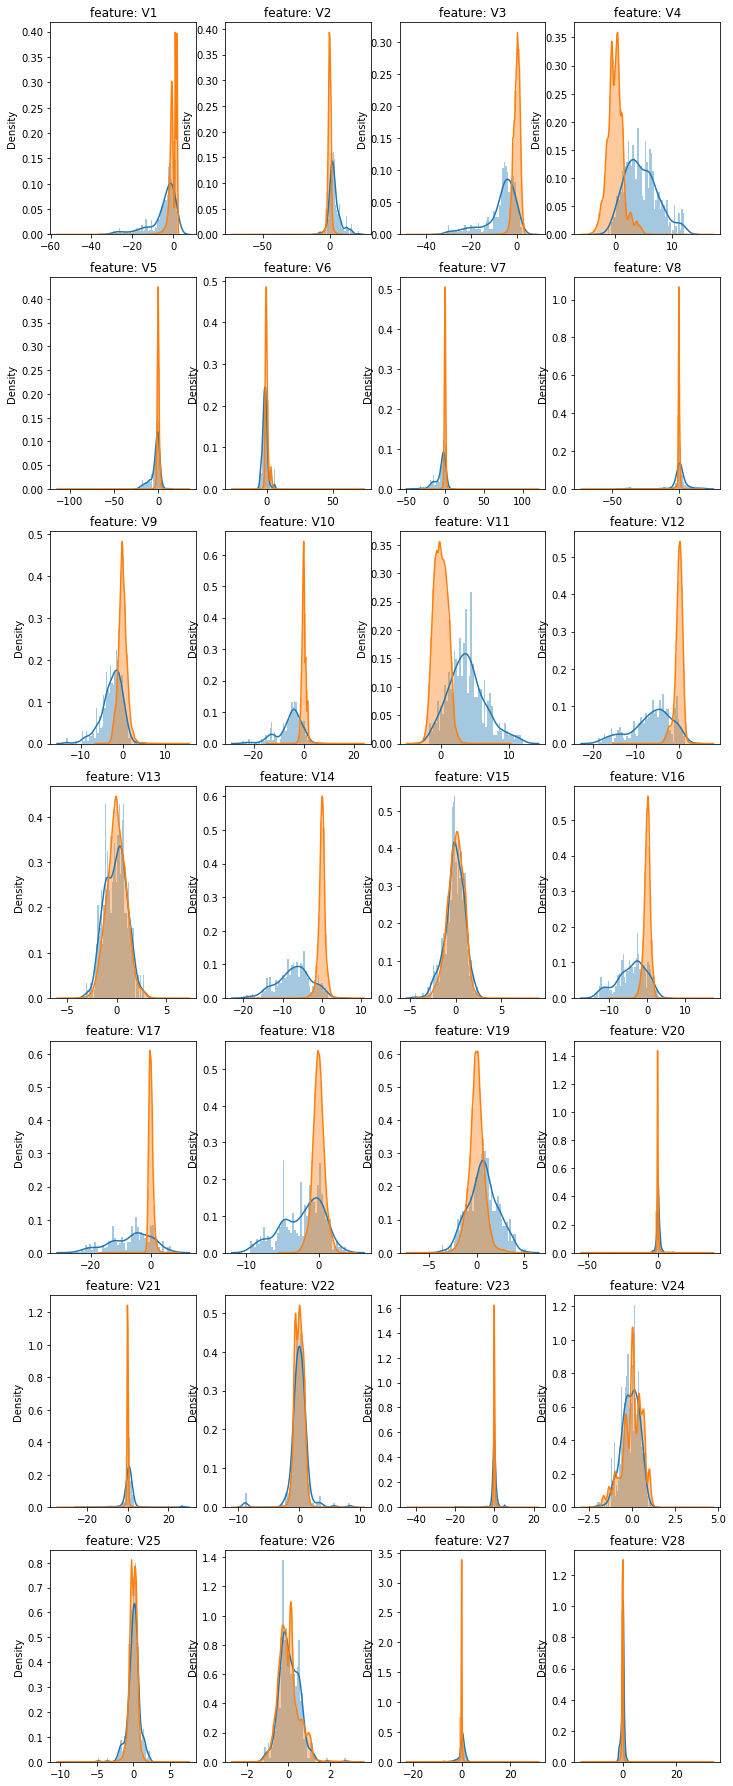

In [13]:
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

### Prediction using Isolation Forest, Local Outlier Factor, SVM 

In [14]:
#Create independent and Dependent Features
columns = df.columns.tolist()

# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)

X = df[columns]
Y = df[target]

X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

In [15]:
##Define the outlier detection methods
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=5, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

C:\Users\ramsu\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



Isolation Forest: 697
Accuracy Score :
0.9975527286899549
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.29      0.29      0.29       492

    accuracy                           1.00    284807
   macro avg       0.65      0.65      0.65    284807
weighted avg       1.00      1.00      1.00    284807

Local Outlier Factor: 935
Accuracy Score :
0.9967170750718908
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.05      0.05      0.05       492

    accuracy                           1.00    284807
   macro avg       0.52      0.52      0.52    284807
weighted avg       1.00      1.00      1.00    284807



- Observations : Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09 When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%. So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.

### Feature Importance

In [ ]:
random_c = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
random_c.fit(df.iloc[:,1:29],df.iloc[:,30]);

In [ ]:
x, y = (list(x) for x in zip(*sorted(zip(random_c.feature_importances_, df.iloc[:,1:29].columns), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)
layout = dict(
    title='Barplot of Feature importances',
     width = 600, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    margin=dict(
    l=300,
),)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

In [ ]:
for name, importance in zip(df.iloc[:,1:29].columns, random_c.feature_importances_):
    if importance > 0.020 :
        print('"' + name + '"'+',')

In [ ]:
df.drop(['V19','V21','V1','V2','V6','V5','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1, inplace = True)
df.drop(labels = ["Amount","Time"], axis = 1, inplace = True)

In [ ]:
## Split the dataset into 2 part one with Class 1 and other with class 0
train_strip_v1 = df[df["Class"] == 1]
train_strip_v0 = df[df["Class"] == 0]

In the Anomalized technique we distribute this large dataset into 3 parts .

- Normal Transactons: classified as 0 , no anomalized transaction should be present here since it is not a supervised method
How to get this dataset :- 60% of normal transactions should be added here.
Find out Epsilon by using min(Probability) command
- dataset for Cross validation : from the remaining normal transaction take 50 % (i.e. 20 % as a whole since we have already took the data in the first step) and add 50% of the Anomalized data with this .
- dataset for testing the algorithm :- this step is similar to what we did for Cross validattion.
Test dataset = leftover normal transaction + leftover Anomalized data

In [ ]:
## Lets Prepare Dataset

Normal_len = len (train_strip_v0)
Anomolous_len = len (train_strip_v1)

start_mid = Anomolous_len // 2
start_midway = start_mid + 1

train_cv_v1  = train_strip_v1 [:start_mid]
train_test_v1 = train_strip_v1 [start_midway:Anomolous_len]

start_mid = (Normal_len * 60) // 100
start_midway = start_mid + 1

cv_mid = (Normal_len * 80) // 100
cv_midway = cv_mid + 1

train_fraud = train_strip_v0[:start_mid]
train_cv    = train_strip_v0[start_midway:cv_mid]
train_test  = train_strip_v0[cv_midway:Normal_len]

train_cv = pd.concat([train_cv,train_cv_v1],axis=0)
train_test = pd.concat([train_test,train_test_v1],axis=0)


print(train_fraud.columns.values)
print(train_cv.columns.values)
print(train_test.columns.values)

train_cv_y = train_cv["Class"]
train_test_y = train_test["Class"]

train_cv.drop(labels = ["Class"], axis = 1, inplace = True)
train_fraud.drop(labels = ["Class"], axis = 1, inplace = True)
train_test.drop(labels = ["Class"], axis = 1, inplace = True)

#### Choosing Epsilon Values

In [ ]:
mu, sigma = estimateGaussian(train_fraud)
p = multivariateGaussian(train_fraud,mu,sigma)
p_cv = multivariateGaussian(train_cv,mu,sigma)
p_test = multivariateGaussian(train_test,mu,sigma)

In [ ]:
#Performance wrt to Epsilon values
#Check out how well we are performing with the given set of epsilon values from the function called here.

fscore, ep= selectThresholdByCV(p_cv,train_cv_y)

In [ ]:
#Epsilon value = 1.0527717316e-70 is selected as threshold to identify Anomalous transactions
#now time to Predict and calculate F1 , Recall and Precision score for our Test Dataset

predictions = (p_test < ep)
Recall = recall_score(train_test_y, predictions, average = "binary")    
Precision = precision_score(train_test_y, predictions, average = "binary")
F1score = f1_score(train_test_y, predictions, average = "binary")    
print ('F1 score , Recall and Precision for Test dataset')
print ('Best F1 Score %f' %F1score)
print ('Best Recall Score %f' %Recall)
print ('Best Precision Score %f' %Precision)

In [ ]:
#Lets Visualize our predictions in below scatter plot 
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(train_test['V14'],train_test['V11'],marker="o", color="lightBlue")
ax.set_title('Anomalies(in red) vs Predicted Anomalies(in Green)')
for i, txt in enumerate(train_test['V14'].index):
       if train_test_y.loc[txt] == 1 :
            ax.annotate('*', (train_test['V14'].loc[txt],train_test['V11'].loc[txt]),fontsize=13,color='Red')
       if predictions[i] == True :
            ax.annotate('o', (train_test['V14'].loc[txt],train_test['V11'].loc[txt]),fontsize=15,color='Green')

- From the above result we can see that we are able to maintain the balance between Recall and Precision.

- Precision of around 87% with Recall of 68% is not bad at all when we have such highly unbalanced data. These numbers are not fixed and can vary .

- These numbers were different for Cross validation dataset and we shortlisted our Epsilon value by comparing the results of F1 Score.

In [ ]:
predictions = (p_cv < ep)
Recall = recall_score(train_cv_y, predictions, average = "binary")    
Precision = precision_score(train_cv_y, predictions, average = "binary")
F1score = f1_score(train_cv_y, predictions, average = "binary")    
print ('F1 score , Recall and Precision for Cross Validation dataset')
print ('Best F1 Score %f' %F1score)
print ('Best Recall Score %f' %Recall)
print ('Best Precision Score %f' %Precision)

**Summary of above Algorithm:**

- Find Epsilon value by considering only Normal Transaction.
- Use this Epsilon value on CV dataset (Normal transaction + Anomalous transaction)
- Come up with set of Epsilon values to see how your algorithm performs and note down the Best F1 score along with Recall and Precision percentage
- Choose the Epsilon value with highest F1 score
- Use this Epsilon value to predict the Anomalous transaction on Test Dataset